In [ ]:
##RNN Cell

import torch
import torch.nn as nn

# A single RNN cell
rnn_cell = nn.RNNCell(input_size=1, hidden_size=1)

# Simple sequence (e.g., time series data)
sequence = torch.tensor([[1], [2], [3], [4]], dtype=torch.float)

# Initial hidden state (usually zeros)
hidden_state = torch.tensor([[0]], dtype=torch.float)
print("Initial Hidden State ",hidden_state)
for i, input in enumerate(sequence):
    hidden_state = rnn_cell(input, hidden_state)
    print(f"Time step {i}: Input {input.item()}, Hidden state {hidden_state.item()}")





Initial Hidden State  tensor([[0.]])
Time step 0: Input 1.0, Hidden state -0.7137192487716675
Time step 1: Input 2.0, Hidden state -0.7120018005371094
Time step 2: Input 3.0, Hidden state -0.8833582997322083
Time step 3: Input 4.0, Hidden state -0.9434736967086792


RNN Layer Example

In [ ]:
# A simple RNN layer
rnn_layer = nn.RNN(input_size=1, hidden_size=1, batch_first=True)

# The same sequence but batched (batch_size, seq_len, input_size)
sequence_batched = sequence.view(1, -1, 1)


In [ ]:
output, hidden = rnn_layer(sequence_batched)

print(f"Output: {output}")
print(f"Last hidden state: {hidden}")


Output: tensor([[[0.6795],
         [0.7339],
         [0.6431],
         [0.4809]]], grad_fn=<TransposeBackward1>)
Last hidden state: tensor([[[0.4809]]], grad_fn=<StackBackward0>)


Next even Number word prediction using RNN .

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


In [ ]:
def generate_even_numbers(start, end):
    return [i for i in range(start, end if end % 2 == 0 else end + 1, 2)]

def normalize_data(data):
    max_val = max(data)
    return [x / max_val for x in data]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# Prepare data
seq_length = 20
data = generate_even_numbers(0, 1000)
normalized_data = normalize_data(data)
X, y = create_sequences(normalized_data, seq_length)
X = X.unsqueeze(-1)  # Adding feature dimension

# DataLoader
batch_size = 1
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
import matplotlib.pyplot as plt

print(X[0],y[0])


tensor([[0.0000],
        [0.0020],
        [0.0040],
        [0.0060],
        [0.0080],
        [0.0100],
        [0.0120],
        [0.0140],
        [0.0160],
        [0.0180],
        [0.0200],
        [0.0220],
        [0.0240],
        [0.0261],
        [0.0281],
        [0.0301],
        [0.0321],
        [0.0341],
        [0.0361],
        [0.0381]]) tensor(0.0401)


In [ ]:
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.linear(out[:, -1, :])  # Take the output of the last time step
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleRNNModel(input_size=1, hidden_size=100, output_size=1, num_layers=2)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
num_epochs = 100
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        hidden = model.init_hidden(batch_size).to(device)
        optimizer.zero_grad()
        output, hidden = model(x_batch, hidden)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {avg_loss}')




Epoch 0 loss: 0.01621063567535791
Epoch 10 loss: 2.424783312364361e-05
Epoch 20 loss: 5.4098017627074445e-05
Epoch 30 loss: 9.770490562641352e-06
Epoch 40 loss: 3.984803363900243e-05
Epoch 50 loss: 2.0120409690906292e-05
Epoch 60 loss: 3.663777580508824e-06
Epoch 70 loss: 3.0288281947072015e-06
Epoch 80 loss: 1.9717382043365806e-06
Epoch 90 loss: 1.3174343944672567e-06


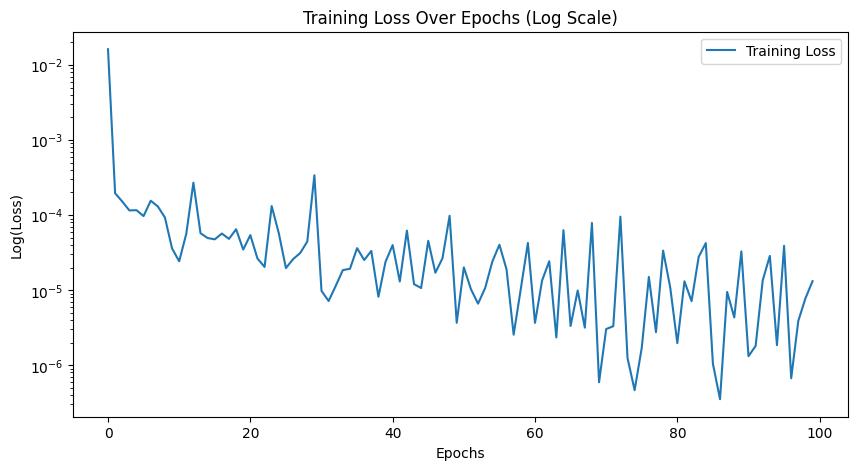

In [ ]:
plt.figure(figsize=(10, 5))
plt.semilogy(epoch_losses, label='Training Loss')  # Logarithmic scale for y-axis
plt.title('Training Loss Over Epochs (Log Scale)')
plt.xlabel('Epochs')
plt.ylabel('Log(Loss)')
plt.legend()
plt.show()



Smotthing Loss curve

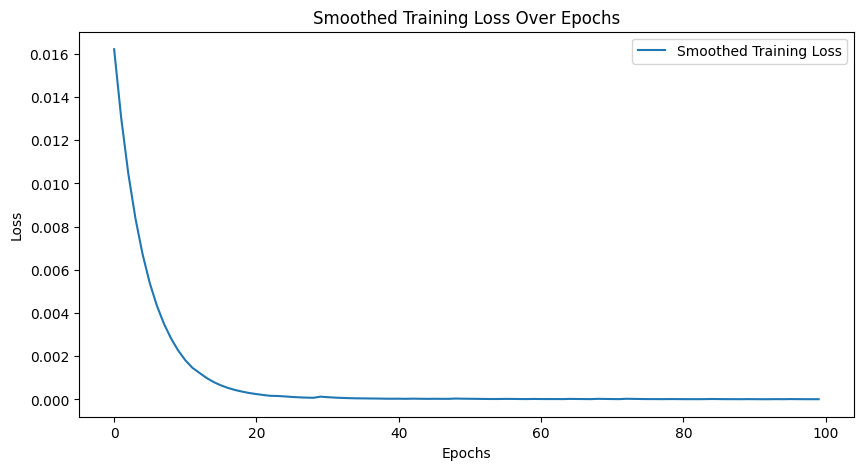

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smoothed_losses = smooth_curve(epoch_losses)

plt.figure(figsize=(10, 5))
plt.plot(smoothed_losses, label='Smoothed Training Loss')
plt.title('Smoothed Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    test_seq = X[-1].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
    hidden = model.init_hidden(batch_size).to(device)
    predicted, _ = model(test_seq, hidden)
    predicted_next_number = (predicted[0].item() * max(data))  # Denormalize
    actual_next_number = data[-1]
    print(f'Actual next number: {actual_next_number}')
    print(f'Predicted next number: {predicted_next_number}')


Actual next number: 998
Predicted next number: 997.7872205972672


#OverShooting Minima Visualization

Loss Function: A simple quadratic function
𝑓
(
𝑥
)
=
𝑥
2
f(x)=x
2
 , which has a minimum at
𝑥
=
0
x=0.
Gradient Descent Implementation:
One with a proper learning rate that converges smoothly.
One with a high learning rate that overshoots the minimum.
Visualization: A plot showing both cases for comparison.

 Explanation of Overshooting Minima
Loss Function: The function
𝑓
(
𝑥
)
=
𝑥
2
f(x)=x
2
  is convex, meaning it has a single minimum at
𝑥
=
0
x=0.
Gradient Descent Updates:
The gradient (derivative) of
𝑓
(
𝑥
)
f(x) is
𝑓
′
(
𝑥
)
=
2
𝑥
f
′
 (x)=2x.
The update rule for gradient descent is:
𝑥
new
=
𝑥
old
−
𝜂
⋅
gradient
x
new
​
 =x
old
​
 −η⋅gradient
where
𝜂
η (learning rate) controls how much we update
𝑥
x.
Effect of Different Learning Rates:
A proper learning rate (
𝜂
=
0.1
η=0.1) allows smooth convergence to the minimum.
A high learning rate (
𝜂
=
0.9
η=0.9) causes overshooting, where
𝑥
x jumps back and forth instead of smoothly decreasing.
🔹 Graph Interpretation
Black Curve: The loss function
𝑓
(
𝑥
)
=
𝑥
2
f(x)=x
2
 .
Blue Dashed Path: Gradient descent with a proper learning rate (smooth convergence).
Red Dashed Path: Gradient descent with a high learning rate, oscillating and overshooting the minimum.
This demonstrates why choosing the right learning rate is crucial in optimization!



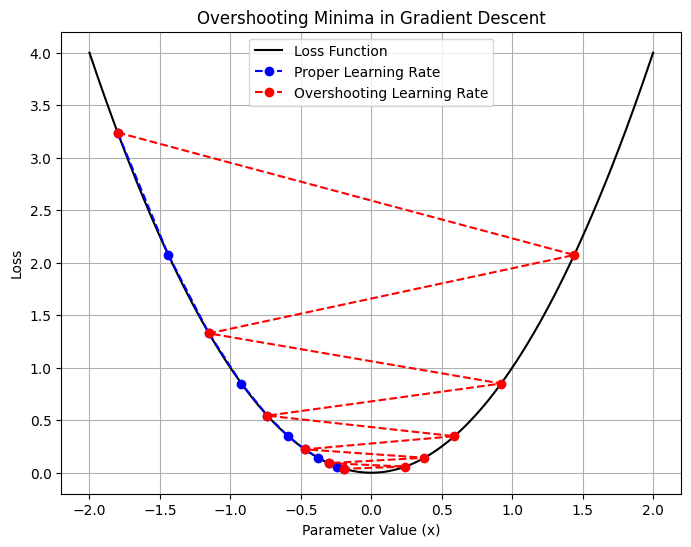

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the loss function (a simple quadratic function)
def loss_function(x):
    return x**2

# Generate x values for visualization
x_vals = np.linspace(-2, 2, 400)
y_vals = loss_function(x_vals)

# Simulate gradient descent with a normal and overshooting learning rate
learning_rates = [0.1, 0.9]  # Normal and high learning rate
colors = ['blue', 'red']
labels = ['Proper Learning Rate', 'Overshooting Learning Rate']

# Initial point
x_start = -1.8

plt.figure(figsize=(8, 6))

# Plot the loss function
plt.plot(x_vals, y_vals, label="Loss Function", color="black")

for lr, color, label in zip(learning_rates, colors, labels):
    x = x_start  # Start point
    trajectory_x = [x]  # Store x values for visualization
    trajectory_y = [loss_function(x)]  # Store loss values

    for _ in range(10):  # Simulate 10 steps of gradient descent
        grad = 2 * x  # Derivative of x^2
        x = x - lr * grad  # Update x using learning rate
        trajectory_x.append(x)
        trajectory_y.append(loss_function(x))

    plt.plot(trajectory_x, trajectory_y, marker="o", linestyle="dashed", color=color, label=label)

# Labels and legend
plt.xlabel("Parameter Value (x)")
plt.ylabel("Loss")
plt.title("Overshooting Minima in Gradient Descent")
plt.legend()
plt.grid()

# Show the plot
plt.show()




---

# **Understanding LSTM (Long Short-Term Memory)**  
LSTM is a type of **Recurrent Neural Network (RNN)** designed to handle **long-term dependencies**. It solves the **vanishing gradient problem** in standard RNNs.  

---

## **LSTM Components**  
LSTM consists of **three gates** and **one memory cell**:  

1. **Forget Gate** (𝑓ₜ) – Decides what past information to remove.  
2. **Input Gate** (𝑖ₜ) – Decides what new information to store.  
3. **Output Gate** (𝑜ₜ) – Decides what to output.  
4. **Cell State** (𝐶ₜ) – Stores long-term memory.  

Each gate uses a **sigmoid function** (𝜎), which outputs values between **0 and 1**, controlling how much information passes through.  

---

## **Step-by-Step Working of LSTM**  

### **1. Forget Gate**  
Decides what portion of the old memory should be removed.  

𝑓ₜ = 𝜎(𝑊𝑓 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝑓)  

where:  
- 𝑓ₜ is the forget gate output.  
- 𝑊𝑓, 𝑏𝑓 are weights and bias.  
- ℎₜ₋₁ is the previous hidden state.  
- 𝑥ₜ is the current input.  
- 𝜎 (sigmoid function) outputs values between **0 and 1** (0 = forget, 1 = keep).  

---

### **2. Input Gate**  
Decides what **new information** should be added.  

1. **Sigmoid function** determines which values to update:  

   𝑖ₜ = 𝜎(𝑊𝑖 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝑖)  

2. **Candidate memory state** is created using **tanh function**:  

   C̃ₜ = tanh(𝑊𝐶 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝐶)  

---

### **3. Update Cell State**  
The **new memory state** is updated as:  

𝐶ₜ = 𝑓ₜ ⋅ 𝐶ₜ₋₁ + 𝑖ₜ ⋅ C̃ₜ  

- The **forget gate** (𝑓ₜ) decides how much of the old memory (𝐶ₜ₋₁) is kept.  
- The **input gate** (𝑖ₜ) determines how much of the new memory (C̃ₜ) is added.  

---

### **4. Output Gate**  
Controls what **final information** should be passed to the next time step.  

1. **Sigmoid function** determines which parts of the memory to output:  

   𝑜ₜ = 𝜎(𝑊𝑜 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏ₒ)  

2. **Final hidden state** is computed using tanh:  

   ℎₜ = 𝑜ₜ ⋅ tanh(𝐶ₜ)  

---

## **Final LSTM Equations**  

1. Forget gate:  

   𝑓ₜ = 𝜎(𝑊𝑓 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝑓)  

2. Input gate:  

   𝑖ₜ = 𝜎(𝑊𝑖 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝑖)  

3. Candidate memory update:  

   C̃ₜ = tanh(𝑊𝐶 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏𝐶)  

4. New cell state:  

   𝐶ₜ = 𝑓ₜ ⋅ 𝐶ₜ₋₁ + 𝑖ₜ ⋅ C̃ₜ  

5. Output gate:  

   𝑜ₜ = 𝜎(𝑊𝑜 ⋅ [ℎₜ₋₁, 𝑥ₜ] + 𝑏ₒ)  

6. Final hidden state:  

   ℎₜ = 𝑜ₜ ⋅ tanh(𝐶ₜ)  

---

## **Breaking It Down Simply**  
- **Forget gate** (𝑓ₜ) → Remove unnecessary old memory.  
- **Input gate** (𝑖ₜ) → Store new important memory.  
- **Cell state** (𝐶ₜ) → Store long-term memory.  
- **Output gate** (𝑜ₜ) → Decide the final output.  

---

## **Key Takeaways**  
- **LSTMs remember long-term dependencies** using a **cell state**.  
- **Three gates (Forget, Input, Output) control memory flow**.  
- **LSTMs solve the vanishing gradient problem** in RNNs.  

---



##LSTM vs RNN

In [ ]:
import torch
import numpy as np

def create_data(sequence_length=200, total_samples=10000):
    data = np.random.rand(total_samples, sequence_length)
    targets = data[:, 0] + data[:, 100]  # Sum of first and fifth elements
    return torch.tensor(data, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

X, y = create_data()
y = y.unsqueeze(1)  # Reshaping for compatibility with model output


In [ ]:
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=10, batch_first=True)
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.linear(out[:, -1, :])

class SimpleLSTM(nn.Module):
    def __init__(self):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, batch_first=True)
        self.linear = nn.Linear(10, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])


In [ ]:
def train_model(model, X, y, epochs=100):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Reshape X for RNN and LSTM
X = X.unsqueeze(-1)  # Adding feature dimension

# Train RNN
rnn_model = SimpleRNN()
print("Training RNN...")
train_model(rnn_model, X, y)

# Train LSTM
lstm_model = SimpleLSTM()
print("\nTraining LSTM...")
train_model(lstm_model, X, y)


##Multi Layer LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



In [ ]:
def generate_even_numbers(start, end):
    return [i for i in range(start, end if end % 2 == 0 else end + 1, 2)]

def normalize_data(data):
    max_val = max(data)
    return [x / max_val for x in data]

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

# Prepare data
seq_length = 20
data = generate_even_numbers(0, 1000)
normalized_data = normalize_data(data)
X, y = create_sequences(normalized_data, seq_length)
X = X.unsqueeze(-1)  # Adding feature dimension

# DataLoader
batch_size = 1
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)



In [ ]:
X[0]

tensor([[0.0000],
        [0.0020],
        [0.0040],
        [0.0060],
        [0.0080],
        [0.0100],
        [0.0120],
        [0.0140],
        [0.0160],
        [0.0180],
        [0.0200],
        [0.0220],
        [0.0240],
        [0.0261],
        [0.0281],
        [0.0301],
        [0.0321],
        [0.0341],
        [0.0361],
        [0.0381]])

In [ ]:
y[0]

tensor(40.)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.linear(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(input_size=1, hidden_size=500, output_size=1, num_layers=2)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
num_epochs = 100

import matplotlib.pyplot as plt

# Store losses for plotting
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0
    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        hidden = model.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))

        optimizer.zero_grad()
        output, hidden = model(x_batch, hidden)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {avg_loss}')



Epoch 0 loss: 0.02921414031196344
Epoch 10 loss: 0.00048359345440509985
Epoch 20 loss: 6.833096865317805e-06
Epoch 30 loss: 5.590684082291154e-06
Epoch 40 loss: 2.5636924710347824e-05
Epoch 50 loss: 4.2830743531361665e-05
Epoch 60 loss: 2.46503394414066e-06
Epoch 70 loss: 7.60795844647667e-05
Epoch 80 loss: 2.755455416868687e-07
Epoch 90 loss: 2.0351118438621922e-05


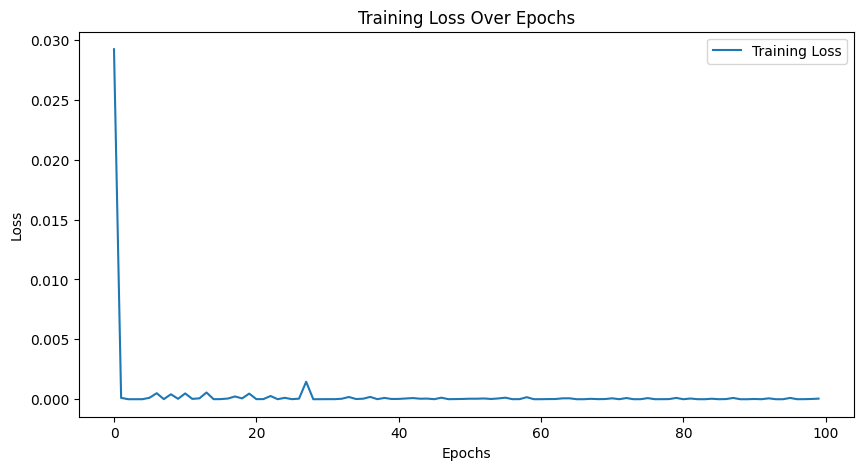

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    test_seq = X[-1].unsqueeze(0).repeat(batch_size, 1, 1).to(device)
    hidden = model.init_hidden(batch_size)
    hidden = (hidden[0].to(device), hidden[1].to(device))

    predicted, _ = model(test_seq, hidden)
    predicted = (predicted[0].item() * max(data))  # Denormalize
    actual = data[-1]
    print(f'Actual next number: {actual}')
    print(f'Predicted next number: {predicted}')


Actual next number: 998
Predicted next number: 997.0951075553894


In [ ]:
test_seq

##Vanishing and exploding gradient graph

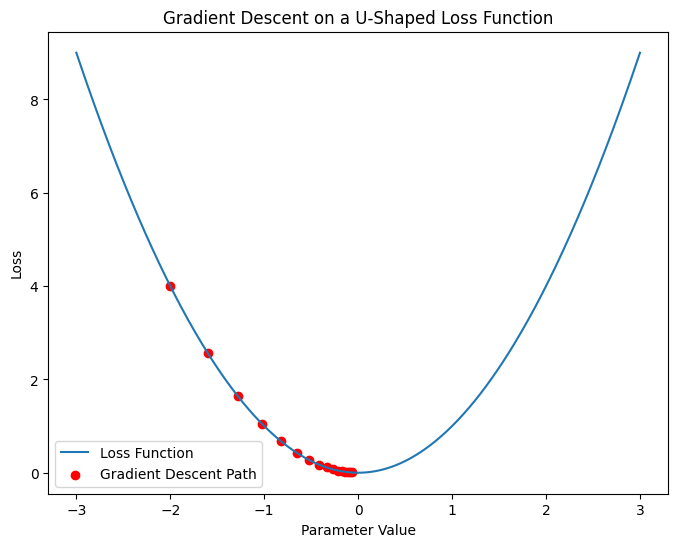

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Defining a simple quadratic loss function and its derivative
def loss_function(x):
    return x**2

def derivative_loss_function(x):
    return 2 * x

# Starting point for gradient descent
start_point = -2
learning_rate = 0.1
iterations = 15

# Performing gradient descent
path = [start_point]
for _ in range(iterations):
    current_point = path[-1]
    gradient = derivative_loss_function(current_point)
    new_point = current_point - learning_rate * gradient
    path.append(new_point)

# Generating points for the loss function curve
x = np.linspace(-3, 3, 400)
y = loss_function(x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='Loss Function')
plt.scatter(path, loss_function(np.array(path)), color='red', marker='o', label='Gradient Descent Path')
plt.title('Gradient Descent on a U-Shaped Loss Function')
plt.xlabel('Parameter Value')
plt.ylabel('Loss')
plt.legend()
plt.show()


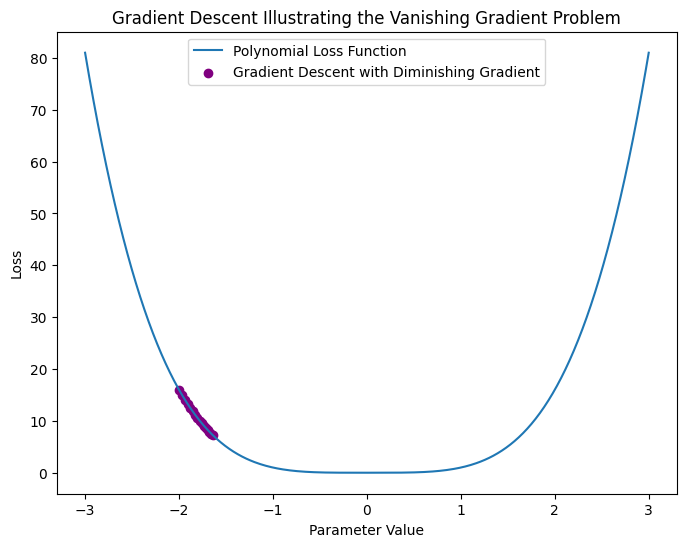

In [ ]:
# Defining a higher-order polynomial loss function and its derivative
def polynomial_loss_function(x):
    return x**4

def derivative_polynomial_loss_function(x):
    return 4 * x**3

# Starting point and settings for the simulation
start_point = -2
learning_rate = 0.001
iterations = 15

# Performing gradient descent with the polynomial loss function
polynomial_path = [start_point]
for _ in range(iterations):
    current_point = polynomial_path[-1]
    gradient = derivative_polynomial_loss_function(current_point)
    new_point = current_point - learning_rate * gradient
    polynomial_path.append(new_point)

# Generating points for the polynomial loss function curve
y_polynomial = polynomial_loss_function(x)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x, y_polynomial, label='Polynomial Loss Function')
plt.scatter(polynomial_path, polynomial_loss_function(np.array(polynomial_path)), color='purple', marker='o', label='Gradient Descent with Diminishing Gradient')
plt.title('Gradient Descent Illustrating the Vanishing Gradient Problem')
plt.xlabel('Parameter Value')
plt.ylabel('Loss')
plt.legend()
plt.show()



##Overshotting Minima

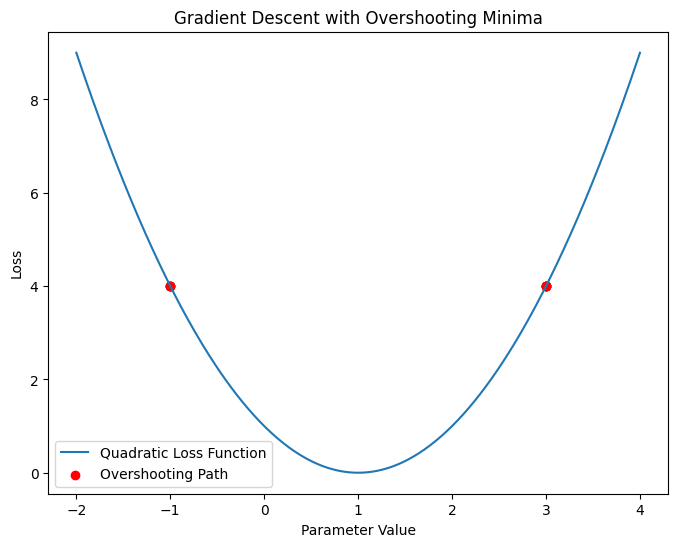

In [ ]:
# Defining a quadratic loss function for simplicity
def quadratic_loss_function(x):
    return (x - 1)**2

# Derivative of the quadratic loss function
def derivative_quadratic_loss_function(x):
    return 2 * (x - 1)

# Simulating gradient descent with a high learning rate to cause overshooting
overshoot_start_point = 3
high_learning_rate = 1.0
overshoot_iterations = 8

# Performing gradient descent
overshoot_path = [overshoot_start_point]
for _ in range(overshoot_iterations):
    current_point = overshoot_path[-1]
    gradient = derivative_quadratic_loss_function(current_point)
    new_point = current_point - high_learning_rate * gradient
    overshoot_path.append(new_point)

# Generating points for the quadratic loss function curve
x_quadratic = np.linspace(-2, 4, 400)
y_quadratic = quadratic_loss_function(x_quadratic)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_quadratic, y_quadratic, label='Quadratic Loss Function')
plt.scatter(overshoot_path, quadratic_loss_function(np.array(overshoot_path)), color='red', marker='o', label='Overshooting Path')
plt.title('Gradient Descent with Overshooting Minima')
plt.xlabel('Parameter Value')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Context Vector Demonstration

In [ ]:
import torch
import torch.nn as nn

# Define a simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)

    def forward(self, input_seq):
        outputs, (hidden, cell) = self.lstm(input_seq)
        return outputs, hidden, cell

# Initialize the model
input_size = 1
hidden_size = 1
model = SimpleLSTM(input_size, hidden_size)

# Create a simple sequence and reshape it to [sequence_length, batch_size, input_size]
sequence = torch.tensor([[[0.1]], [[0.2]], [[0.3]]])

# Pass the sequence through the model and print context vectors
with torch.no_grad():
    outputs, hidden, cell = model(sequence)
    print("Outputs of each step: ", outputs)
    print("Final hidden state: ", hidden)
    print("Final cell state: ", cell)


Outputs of each step:  tensor([[[0.4572]],

        [[0.6711]],

        [[0.7644]]])
Final hidden state:  tensor([[[0.7644]]])
Final cell state:  tensor([[[1.3879]]])


##Stock Prediction

In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf
import pandas as pd

# Ticker symbol for Reliance Industries Limited
stock_symbol = 'RELIANCE.NS'

# Dates for the past two years
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=2)

# Downloading the data
data = yf.download(stock_symbol, start=start_date, end=end_date)

print(data.tail())  # This line will print the last few rows of the data


[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2024-01-16  2779.949951  2792.600098  2741.000000  2749.250000  2749.250000   
2024-01-17  2719.000000  2772.550049  2710.050049  2723.149902  2723.149902   
2024-01-18  2702.800049  2742.000000  2702.500000  2735.899902  2735.899902   
2024-01-19  2752.000000  2752.000000  2718.000000  2734.899902  2734.899902   
2024-01-20  2730.000000  2766.949951  2700.000000  2713.300049  2713.300049   

             Volume  
Date                 
2024-01-16  4534512  
2024-01-17  6098691  
2024-01-18  5139719  
2024-01-19  5211352  
2024-01-20  3640282  


In [ ]:
!pip install matplotlib pandas


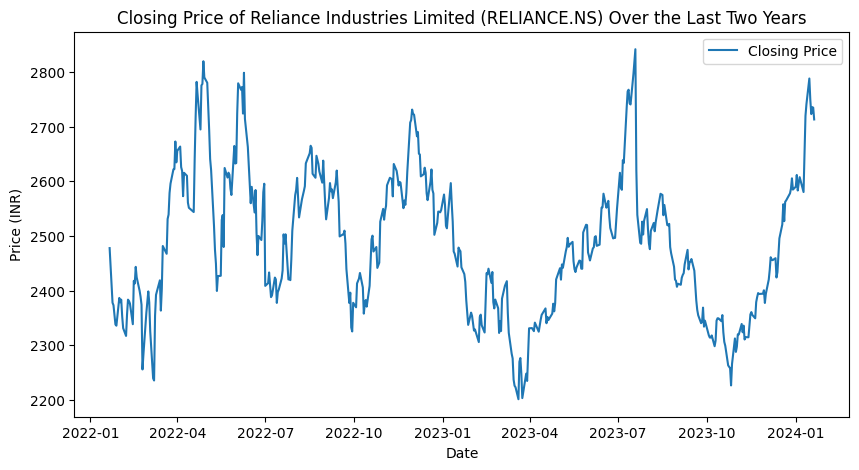

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data' is the DataFrame you obtained from yfinance
# Plotting the closing prices
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Closing Price')
plt.title('Closing Price of Reliance Industries Limited (RELIANCE.NS) Over the Last Two Years')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.show()

#Month wise Prediction

[*********************100%%**********************]  1 of 1 completed


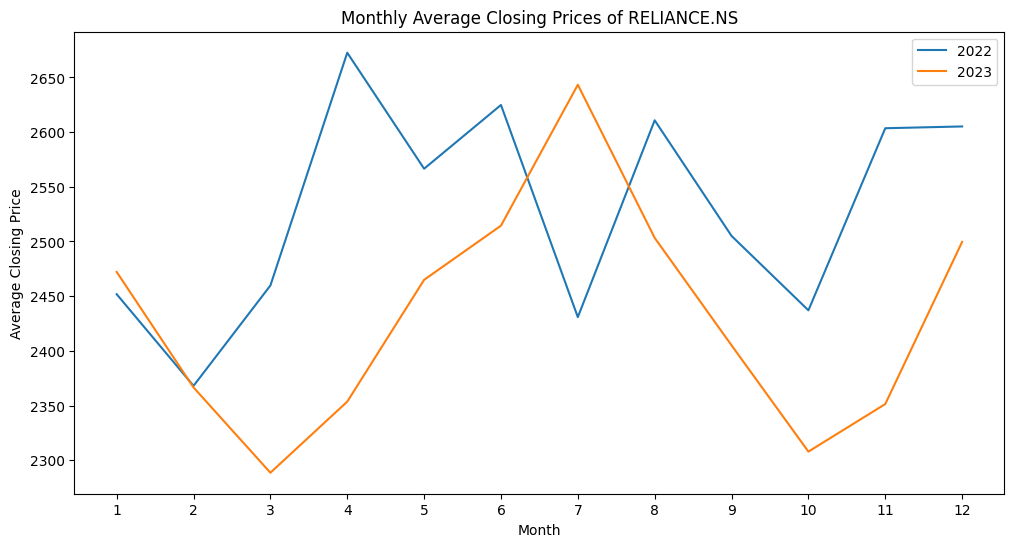

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Fetching the data (using Reliance Industries Limited as an example)
stock_symbol = 'RELIANCE.NS'
data = yf.download(stock_symbol, start="2022-01-01", end="2024-01-01")

# Adding year and month columns
data['Year'] = data.index.year
data['Month'] = data.index.month

# Grouping by year and month
monthly_data = data.groupby(['Year', 'Month']).mean()

# Plotting the data
plt.figure(figsize=(12, 6))

for year in monthly_data.index.levels[0]:
    plt.plot(monthly_data.loc[year]['Close'], label=f'{year}')

plt.title(f'Monthly Average Closing Prices of {stock_symbol}')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.legend()
plt.xticks(range(1, 13))  # Set x-ticks to be each month
plt.show()


In [ ]:
!pip install mplfinance


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.5 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


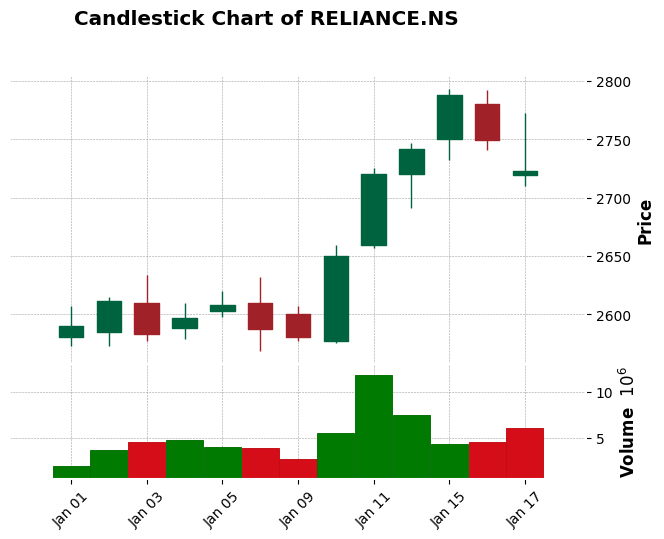

In [ ]:
import yfinance as yf
import mplfinance as mpf

# Fetching the data (using Reliance Industries Limited as an example)
stock_symbol = 'RELIANCE.NS'
data = yf.download(stock_symbol, start="2024-01-01", end="2024-01-18")

# Plotting the candlestick chart
mpf.plot(data, type='candle', style='charles',
         title=f'Candlestick Chart of {stock_symbol}',
         volume=True, mav=(20,50,100))


In [ ]:
!pip install yfinance


In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = 'RELIANCE.NS' # This is the ticker for Reliance Industries on NSE

# Define the time frame
start_date = '2023-01-01'
end_date = '2024-01-01'

# Fetch the data
data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1h')

# Save the data to a CSV file
data.to_csv('reliance_stock_data.csv')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('reliance_stock_data.csv')
prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)

# Parameters
sequence_length = 30  # Increased sequence length
hidden_size = 50
num_layers = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.001
input_size = 1
output_size = 1

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Prepare data
train_size = int(len(prices) * 0.8)
test_size = len(prices) - train_size
train_data, test_data = prices[0:train_size,:], prices[train_size:len(prices),:]
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

# Convert to tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

In [ ]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
##LSTM Model with enhancements
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(EnhancedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Adding more layers and dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Using only the last output for prediction
        return out

# Parameters
hidden_size_a = 100  # Increased hidden layer size
num_layers_a = 3     # Increased number of layers
dropout_prob = 0.3 # Dropout probability

Epoch [1/100], Loss: 0.1850
Epoch [11/100], Loss: 0.0405
Epoch [21/100], Loss: 0.0321
Epoch [31/100], Loss: 0.0277
Epoch [41/100], Loss: 0.0224
Epoch [51/100], Loss: 0.0078
Epoch [61/100], Loss: 0.0044
Epoch [71/100], Loss: 0.0037
Epoch [81/100], Loss: 0.0030
Epoch [91/100], Loss: 0.0025


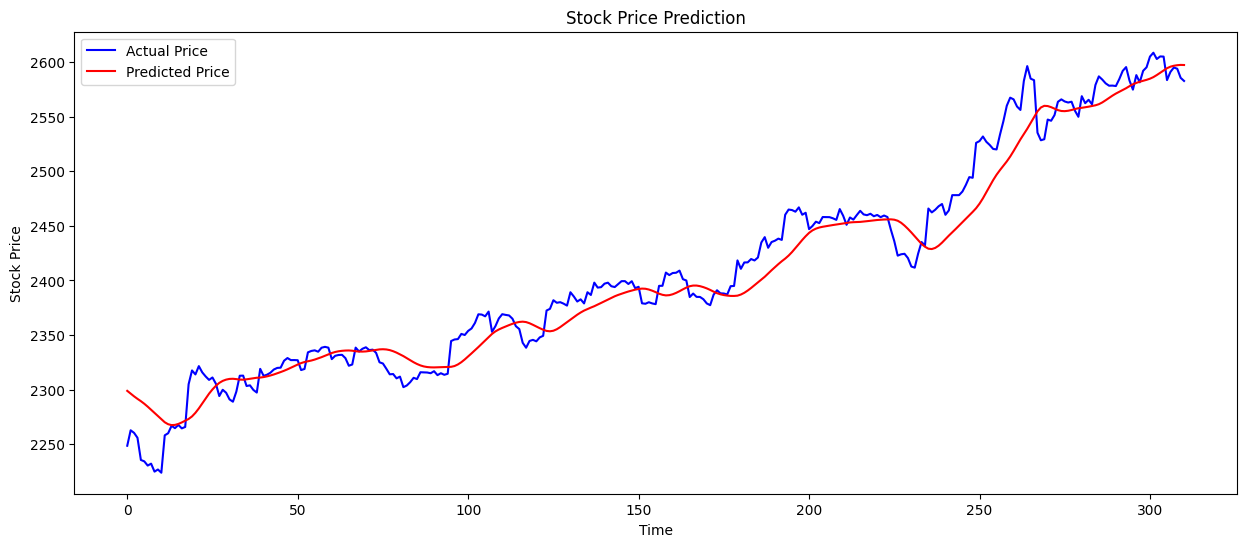

In [ ]:



# Instantiate the model
#model = LSTM(input_size, hidden_size, num_layers, output_size)
model = EnhancedLSTM(input_size, hidden_size_a, num_layers_a, output_size, dropout_prob)

# Loss and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing
model.eval()
test_predict = model(x_test)

# Inverse transform to get actual predictions
test_predict = scaler.inverse_transform(test_predict.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# Plot
plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


 Let's break down the script into smaller steps and explain each part in detail, making it easier for students to understand how the enhanced LSTM model for stock price prediction works.

### Step 1: Import Required Libraries

```python
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
import matplotlib.pyplot as plt
```

- **torch**: The main PyTorch library.
- **torch.nn**: Provides necessary tools to build neural networks in PyTorch.
- **numpy**: Used for numerical operations on arrays.
- **pandas**: Used for data manipulation and reading the CSV file.
- **MinMaxScaler from sklearn.preprocessing**: Scales the data to a range, which is essential for neural network inputs.
- **matplotlib.pyplot**: Used for plotting graphs.

### Step 2: Load and Normalize Data

```python
data = pd.read_csv('reliance_stock_data.csv')
prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices = scaler.fit_transform(prices)
```

- The data is loaded from a CSV file (`reliance_stock_data.csv`), specifically the 'Close' prices of stocks.
- The prices are reshaped and normalized using `MinMaxScaler` to ensure they are suitable for use in the neural network.

### Step 3: Define Parameters

```python
sequence_length = 30
hidden_size = 100
num_layers = 3
num_epochs = 100
batch_size = 16
learning_rate = 0.001
input_size = 1
output_size = 1
dropout_prob = 0.3
```

- **sequence_length**: How many time steps of data the network sees before making a prediction.
- **hidden_size**: The number of features in the hidden state of the LSTM.
- **num_layers**: Number of stacked LSTM layers.
- **num_epochs**: Number of times the entire dataset is passed forward and backward through the neural network.
- **batch_size**: The size of input data taken in one iteration for training.
- **learning_rate**: Step size at each iteration while moving toward a minimum of a loss function.
- **input_size**: The number of input features (in this case, 1, as we are only using the closing price).
- **output_size**: The number of output features (1, as we predict the next closing price).
- **dropout_prob**: Probability of dropping out neurons during training to prevent overfitting.

### Step 4: Create Sequences from Data

```python
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
```

- This function creates sequences from the data. Each sequence (x) is a series of past stock prices used to predict the next price (y).

### Step 5: Split Data into Training and Testing

```python
train_size = int(len(prices) * 0.8)
test_size = len(prices) - train_size
train_data, test_data = prices[0:train_size,:], prices[train_size:len(prices),:]
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)
```

- The data is split into training (80%) and testing (20%) sets.
- Sequences are created for both training and testing data.

### Step 6: Convert to PyTorch Tensors

```python
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()
```

- The training and testing data are converted to PyTorch tensors, which are the data structures used in PyTorch for model training.

### Step 7: Define the Enhanced LSTM Model

```python
class EnhancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.5):
        super(EnhancedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
```

- This class defines the enhanced LSTM model.
- It uses multiple LSTM layers with dropout for regularization.
- The `forward` method defines how the data flows through the model.

### Step 8: Instantiate the Model, Define Loss Function and Optimizer

```python
enhanced_model = EnhancedLSTM(input_size, hidden_size, num_layers, output_size, dropout_prob)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(enhanced_model.parameters(), lr=learning_rate)
```

- An instance of the EnhancedLSTM model is created.
- Mean Squared Error (MSE) is used as the loss function.
- Adam optimizer is used for optimizing the model.

### Step 9: Train the Model

```python
for epoch in range(num_epochs):
    enhanced_model.train()
    outputs = enhanced_model(x_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
```

- The model is trained over a specified number of epochs.
- In each epoch, the model makes predictions, calculates loss, and updates its weights.

### Step 10: Test the Model and Plot Results

```python
enhanced_model.eval()
test_predict = enhanced_model(x_test)
test_predict = scaler.inverse_transform(test_predict.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

plt.figure(figsize=(15, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predict, label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
```

- The model is switched to evaluation mode.
- Predictions are made on the test set.
- The predictions and actual prices are plotted for comparison.

This completes the end-to-end process of building and using an enhanced LSTM model for stock price prediction. Each step is crucial for understanding how LSTM models are used in practical applications like stock price forecasting.

Multivariate


Creating a multivariate LSTM model for stock prediction in PyTorch involves using multiple features (like open, high, low, close prices, and volume) to predict future stock prices. Here's a Python script demonstrating this process:

### Install Necessary Libraries
Ensure you have `yfinance`, `pandas`, `numpy`, `torch`, and related libraries installed. You can install them using pip:

```bash
pip install yfinance pandas numpy torch
```

### Python Script for Multivariate LSTM Stock Prediction

```python
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Download stock data
def download_stock_data(stock_symbol, start_date, end_date):
    return yf.download(stock_symbol, start=start_date, end=end_date)

# Multivariate LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

# Preprocessing Data
def preprocess_data(data, feature_columns, target_column, window_size):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[feature_columns])

    X, y = [], []
    for i in range(window_size, len(data_scaled)):
        X.append(data_scaled[i-window_size:i])
        y.append(data_scaled[i, target_column])
    
    return np.array(X), np.array(y)

# Main function
if __name__ == "__main__":
    stock_symbol = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2022-01-01'
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    target_column = 3 # 'Close' column index
    window_size = 50
    test_size = 0.2
    epochs = 50
    batch_size = 64

    # Load data
    stock_data = download_stock_data(stock_symbol, start_date, end_date)

    # Preprocess data
    X, y = preprocess_data(stock_data, feature_columns, target_column, window_size)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Create model
    input_size = len(feature_columns)
    hidden_layer_size = 64
    output_size = 1
    model = LSTM(input_size, hidden_layer_size, output_size)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train model
    for epoch in range(epochs):
        for i in range(0, len(X_train), batch_size):
            batch_X, batch_y = X_train[i:i+batch_size], y_train[i:i+batch_size]
            optimizer.zero_grad()
            model_output = model(batch_X)
            loss = loss_function(model_output, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')

    # Evaluate the model on test data
    # Implement your evaluation logic here

    # Predict and visualize results
    # Implement prediction and visualization logic here
```

### Explanation
1. **Data Acquisition**: The script downloads stock data using Yahoo Finance.
2. **Multivariate LSTM Model**: It defines an LSTM class suitable for handling multiple input features.
3. **Data Preprocessing**: The data is scaled, and a sliding window approach is used to create sequences of past observations (features) and the corresponding target (future close price).
4. **Training and Testing Sets**: The data is split into training and testing sets.
5. **Model Training**: The LSTM model is trained on the training data.
6. **Evaluation and Prediction**: The script needs additional implementation for evaluating the model on test data and making future predictions.

### Considerations
- **Data Splitting**: Time series data is sequential; consider using time-based splitting instead of random splitting for training and testing sets.
- **Hyperparameters**: The choice of `window_size`, `hidden_layer_size`, and other hyperparameters significantly affects model performance and should be tuned.
- **Model Evaluation**: Implement evaluation metrics such as RMSE to assess the model's performance.
- **Prediction Logic**: To make future predictions, feed the most recent data points into the model.

This script is a starting point, and it's important to tailor it according to your specific needs and to perform thorough validation and testing before using it for actual trading decisions. Remember, stock market prediction is complex and should be approached with caution.

To complete the multivariate LSTM model for stock prediction, I'll provide the script segments for model evaluation and making predictions. This will include evaluating the model on the test set and using the model to make future predictions.

### Continuing from the Previous Script

#### 4. Model Evaluation

After training the model, we can evaluate its performance on the test set. Common metrics for evaluation include Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).

```python
# Evaluation on Test Data
model.eval()  # Set the model to evaluation mode
test_predictions = model(X_test)
test_loss = loss_function(test_predictions, y_test.view(-1, 1))
print(f'Test Loss: {test_loss.item()}')

# Calculate RMSE for more interpretable results
rmse = torch.sqrt(test_loss).item()
print(f'Test RMSE: {rmse}')
```

#### 5. Making Predictions

For making predictions, you typically want to use the most recent data points and pass them through the model to predict future stock prices.

```python
# Making Future Predictions
# Assuming you want to predict the next day's closing price after the end date
# We will use the last `window_size` days from the data as input
last_window = X[-window_size:].reshape(1, window_size, -1)
last_window = torch.tensor(last_window, dtype=torch.float32)

model.eval()
predicted_price_normalized = model(last_window).item()

# Inverse transform to get actual predicted price
predicted_price = scaler.inverse_transform([[predicted_price_normalized] * len(feature_columns)])[0][0]
print(f'Predicted Closing Price: {predicted_price}')
```

#### Full Script Integration

Integrate these segments into the main script after the training loop. Remember that the `scaler` used for inverse transformation should be the one fitted on the 'Close' prices initially.

### Important Notes

- **Data Window for Prediction**: For making a future prediction, you need to use the most recent data available, structured in the same way as your training data (i.e., respecting the `window_size`).
- **Model State**: Ensure the model is in evaluation mode (`model.eval()`) before making predictions to disable dropout layers or batch normalization layers that behave differently during training.
- **Inverse Transformation**: It's essential to apply the inverse transformation to the predictions because the model outputs data in the scaled format.

This script gives you a basic framework for evaluating and making predictions with a multivariate LSTM model in PyTorch. For real-world applications, more sophisticated techniques in data preprocessing, feature engineering, model validation, and error analysis are necessary. Stock market prediction is inherently complex and should be approached with caution and thorough analysis.